<a href="https://colab.research.google.com/github/nebaraka/dissertation/blob/main/Dissertation_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [37]:
import tensorflow_hub as hub
import os
import zipfile
import re
from skimage.transform import rescale, resize
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras import Sequential
from keras.callbacks import TensorBoard
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from keras.layers import Reshape
import IPython.display as display
import datetime
import seaborn
from google.colab import files

In [13]:
with zipfile.ZipFile('drive/MyDrive/In-shop Clothes Retrieval Benchmark/Img/img.zip', 'r') as zip_ref:
     zip_ref.extractall('img')

In [14]:
PATH = 'img/img/WOMEN/'

In [15]:
labels = os.listdir(PATH)

In [16]:
a = np.zeros(len(labels))

In [17]:
l_to_n = {}

In [18]:
for i in range(len(labels)):
  num = np.zeros(len(labels))
  num[i] = 1
  l_to_n[labels[i]] = num

In [19]:
n_to_l = {np.argmax(v):k for k, v in l_to_n.items()}

In [20]:
%%time
X = []
Y = []
for folder in os.listdir(PATH):
  for subfolder in os.listdir(PATH + folder):
    for img in os.listdir(PATH + folder + '/' + subfolder):
      if bool(re.fullmatch(".*front.*", img)):
          X.append(resize(tf.image.convert_image_dtype(tf.image.decode_jpeg(
              tf.io.read_file(PATH + folder + '/' + subfolder + '/' + img)), tf.float32), (224, 224, 3),
                       anti_aliasing=True))
          Y.append(l_to_n[folder])
          break

CPU times: user 1min 44s, sys: 1min 38s, total: 3min 22s
Wall time: 1min 45s


In [21]:
X = np.array(X)
Y = np.array(Y)

### Mean image in class

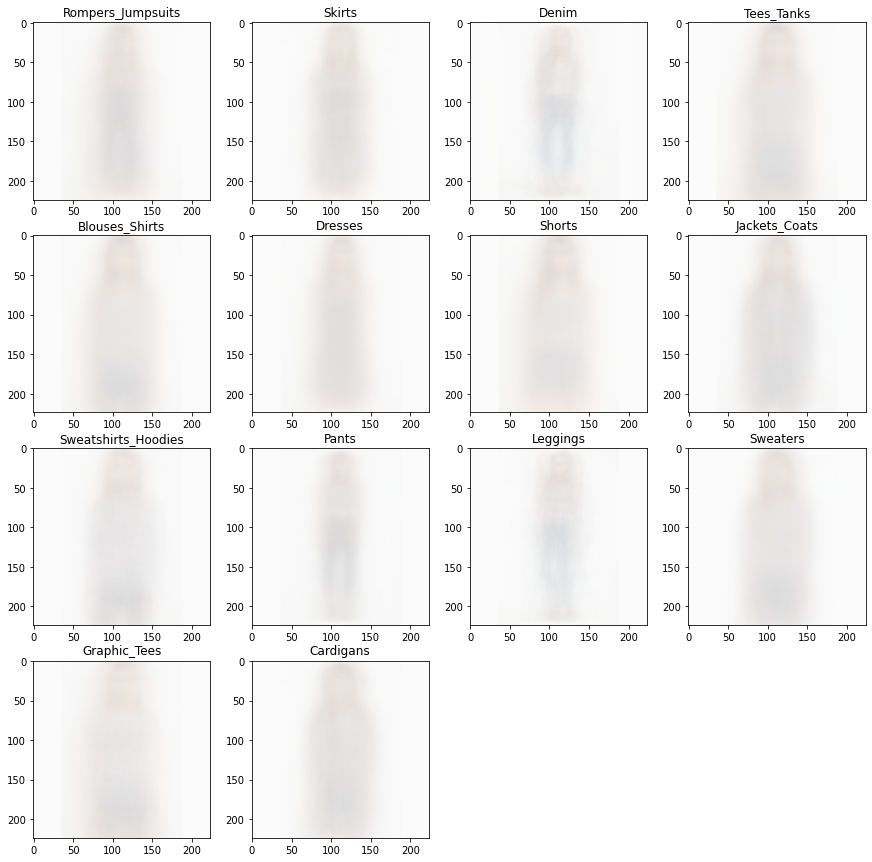

In [22]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
ax = []
classes = np.apply_along_axis(lambda x: np.argmax(x), axis=1, arr=Y)
for i in range(columns*rows - 2):
    img = X[np.where(classes == i)].mean(axis=0)
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(n_to_l[i])  # set title
    plt.imshow(img, alpha=0.25)
plt.show()

### Classes distribution

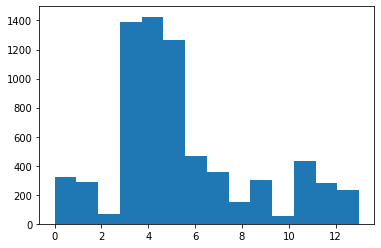

In [23]:
plt.figure()
plt.hist(classes, bins=14)
plt.show()

In [24]:
%load_ext tensorboard

In [25]:
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [26]:
num_classes = 14

In [ ]:
feature_extractor = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
                   trainable=False)

In [ ]:
model = tf.keras.Sequential([
    feature_extractor,
    # tf.keras.layers.Dense(1664, activation='relu'),
    # tf.keras.layers.Dense(1664, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])  # Batch input shape.

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [27]:
del X
del Y

In [29]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [30]:
N_EPOCHS = 10

In [ ]:
history = model.fit(X_train, Y_train,
                    batch_size=35,
                    epochs=N_EPOCHS, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs

In [ ]:
!rm -r logs

In [ ]:
del model
feature_extractor.trainable = True
clf = model.layers[1]
model = tf.keras.Sequential([
    feature_extractor,
    clf
])
model.build([None, 224, 224, 3])  # Batch input shape.

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
N_EPOCHS = 100

In [ ]:
history = model.fit(X_train, Y_train,
                    batch_size=35,
                    epochs=N_EPOCHS, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs

### Metrics

In [29]:
# del Y_pred
Y_pred = model.predict(X_test)

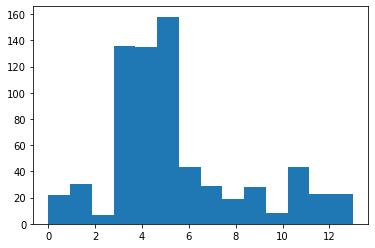

In [32]:
# Test objects distribution
plt.figure()
plt.hist(np.argmax(Y_pred, axis=1), bins=14)
plt.show()

In [30]:
sklearn.metrics.f1_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), average='macro')

0.9313686241546923

In [33]:
conf_m = sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

In [34]:
n_to_l

{0: 'Rompers_Jumpsuits',
 1: 'Skirts',
 2: 'Denim',
 3: 'Tees_Tanks',
 4: 'Blouses_Shirts',
 5: 'Dresses',
 6: 'Shorts',
 7: 'Jackets_Coats',
 8: 'Sweatshirts_Hoodies',
 9: 'Pants',
 10: 'Leggings',
 11: 'Sweaters',
 12: 'Graphic_Tees',
 13: 'Cardigans'}

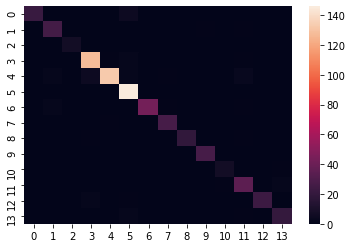

In [35]:
seaborn.heatmap(conf_m)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1664)              3766048   
_________________________________________________________________
dense_1 (Dense)              (None, 14)                23310     
Total params: 3,789,358
Trainable params: 3,745,102
Non-trainable params: 44,256
_________________________________________________________________


In [ ]:
model.save('women100mobile-net.h5')
files.download("women100mobile-net.h5")